# Issues in practice

<br><br><br><br><br>

## Which library to use?

**Many (canned) algorithms:**

<table>
    <tr style="background: white;">
        <td><img src="https://upload.wikimedia.org/wikipedia/commons/0/05/Scikit_learn_logo_small.svg" style="height: 90px;"></td>
    </tr>
</table>

* Scikit-Learn's algorithms have a common interface, which makes it easy to learn a new one, but they're not flexible (only configurable by a long list of function arguments).

<br><br>

**Neural networks:**

<table>
    <tr style="background: white;">
        <td style="text-align: center; padding-right: 15px;"><img src="https://upload.wikimedia.org/wikipedia/commons/a/ab/TensorFlow_logo.svg" style="height: 140px;"></td>
        <td style="text-align: center; padding-left: 15px;"><img src="https://keras.io/img/logo.png" style="height: 60px;"></td>
    </tr> <tr style="background: white;">
        <td style="text-align: center; padding-right: 15px;"><img src="https://upload.wikimedia.org/wikipedia/commons/c/c6/PyTorch_logo_black.svg" style="height: 45px;"></td>
        <td style="text-align: center; padding-left: 15px;"><img src="https://raw.githubusercontent.com/valohai/ml-logos/master/mxnet.svg" style="height: 60px;"></td>
    </tr>
</table>

* TensorFlow and Keras merged, with Keras becoming the high-level interface to TensorFlow.
* TensorFlow tends to be associated more with industry and production environments; PyTorch tends to be associated more with academic research.
  * In PyTorch, the training loop (feeding the algorithm batches of data to fit) is just a Python for loop, which makes it easy to develop and debug.
  * In TensorFlow 2.0 (2019) and later, training can be done this way as well.
  * Both can be hard to install if you're trying to use a GPU (hard to match your CUDA library version).
* MXNet is much less popular than TensorFlow and PyTorch, and development ended recently (2023).

<br><br>

**Neural network-capable array library:**

<table>
    <tr style="background: white;">
        <td><img src="https://upload.wikimedia.org/wikipedia/commons/8/86/Google_JAX_logo.svg" style="height: 75px;"></td>
    </tr>
</table>

* JAX is a NumPy replacement with support for GPU, autodiff, and JIT-compilation, which makes it possible to build new algorithms from scratch.
  * Same installation troubles with GPUs/CUDA.

<br><br>

**Boosted decision trees:**

<table>
    <tr style="background: white;">
        <td style="text-align: center; padding-right: 30px; padding-bottom: 25px;"><img src="https://upload.wikimedia.org/wikipedia/commons/6/69/XGBoost_logo.png" style="height: 60px;"></td>
        <td style="text-align: center;"><img src="https://upload.wikimedia.org/wikipedia/commons/d/d9/LightGBM_logo_black_text.svg" style="height: 45px;"></td>
        <td style="text-align: center; padding-left: 30px;"><img src="https://upload.wikimedia.org/wikipedia/commons/c/cc/CatBoostLogo.png" style="height: 70px; vertical-align: middle; padding-bottom: 15px;"> <span style="font-size: 18pt;">CatBoost</span></td>
</table>

* Boosted decision trees are still relevant for problems with well-chosen input features.

<br><br><br><br><br>

### What does everyone else use?

Using techniques described [here](https://indico.jlab.org/event/459/contributions/11547/) and [here](https://github.com/jpivarski-talks/2023-05-09-chep23-analysis-of-physicists), this is the number of times each ML library is imported, semiannually, in code written by CMS physicists:

<img src="../img/github-ml-package-cmsswseed.svg" width="900">

* Scikit-Learn is oldest and still widely used
* TensorFlow is dominant (and used to be imported with Keras, but not so much anymore)
* PyTorch is increasingly significant
* XGBoost is also common
* JAX and the other libraries are not widely used

<br><br><br><br><br>

Using Google Trends (world search volume, not just physicists):

<img src="../img/google-ml-package.svg" width="900">

* PyTorch saw a burst of interest since 2023, but it's because of LLMs:

<img src="../img/google-ml-llm-package.svg" width="900">

* That's not relevant for HEP, though it would be interesting to extend my analysis of CMS physicsts one more year.

<br><br><br><br><br>

### What will this mini-course use?

Scikit-Learn for linear fits and simple neural networks.

PyTorch for neural network architectures, because it's easier to illustrate the parts.

<br><br>

Most of the examples in _this lesson_ are linear fits because the issues that I'll be discussing are general.

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.linear_model
import torch
from torch import nn, optim

<br><br><br><br><br>

## Regression versus classification, loss functions

When we think of fitting, we usually think of regression:

In [35]:
penguins_df = pd.read_csv("../data/penguins.csv")

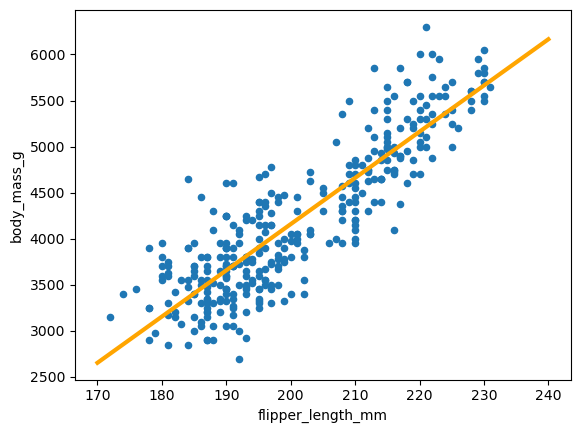

In [74]:
model = sklearn.linear_model.LinearRegression()
model.fit(penguins_df.dropna()["flipper_length_mm"].values[:, np.newaxis], penguins_df.dropna()["body_mass_g"])

model_x = np.linspace(170, 240, 2)
model_y = model.predict(model_x[:, np.newaxis])

fig, ax = plt.subplots()

penguins_df.plot.scatter("flipper_length_mm", "body_mass_g", ax=ax)
ax.plot(model_x, model_y, color="orange", linewidth=3)

None

Given $x$ values drawn from a vector space, the model responds with the most likely $y$ values, which also come from a vector space (that is, they're real-valued, maybe more than one of them).

<br><br><br><br><br>

Sometimes, though, you're interested in _categorical_ data, like the colors of the dots in the TensorFlow Playground exercise.

In general, there are [four levels of measurement](https://en.wikipedia.org/wiki/Level_of_measurement),

| Level | Math | Description | Physics example |
|:--|:--:|:--|:--|
| Nominal category | =, ≠ | categories without order | jet classification, data versus Monte Carlo |
| Ordinal category | >, < | categories that have an order | barrel region, overlap region, endcap region |
| Interval number | +, ‒ | doesn't have an origin | energy, voltage, position, momentum |
| Ratio number | ×, / | has an origin | absolute temperature, mass, opening angle |

But generally, we only need to be concerned about categorical versus numerical.

<br><br><br><br><br>

Suppose we have data from two distinct categories that have different, but overlapping, distributions.

In [65]:
adelie_df = penguins_df[penguins_df["species"] == "Adelie"][["bill_length_mm", "bill_depth_mm"]].dropna()
gentoo_df = penguins_df[penguins_df["species"] == "Gentoo"][["bill_length_mm", "bill_depth_mm"]].dropna()

<img src="../img/culmen_depth.png" width="300">

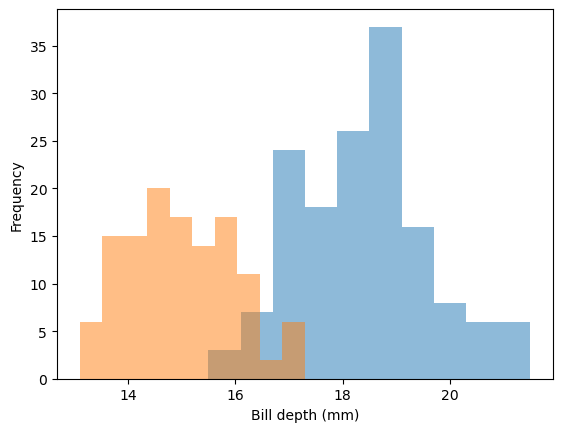

In [314]:
fig, ax = plt.subplots()

adelie_df["bill_depth_mm"].plot.hist(alpha=0.5)
gentoo_df["bill_depth_mm"].plot.hist(alpha=0.5)

ax.set_xlabel("Bill depth (mm)")

None

We can express the two categories as values 0 and 1 in a numeric dataset:

In [109]:
species = np.concatenate([np.zeros(len(adelie_df)), np.ones(len(gentoo_df))])
bill_depth = np.concatenate([adelie_df["bill_depth_mm"].values, gentoo_df["bill_depth_mm"].values])

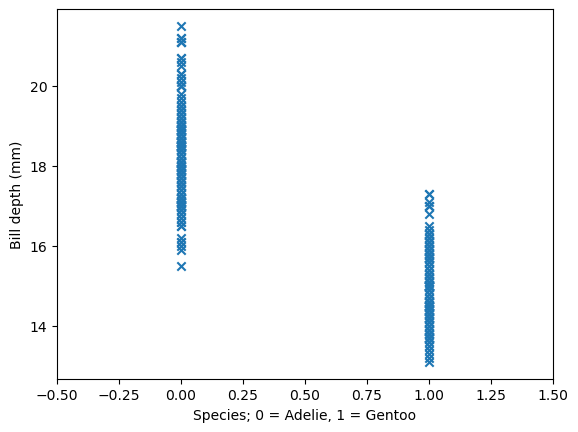

In [117]:
fig, ax = plt.subplots()

ax.scatter(species, bill_depth, marker="x")

ax.set_xlabel("Species; 0 = Adelie, 1 = Gentoo")
ax.set_ylabel("Bill depth (mm)")
ax.set_xlim(-0.5, 1.5)

None

<br><br><br><br><br>

If we are intending to use the categorical data as a _feature_, an input to the model, then we can fit it as-is.

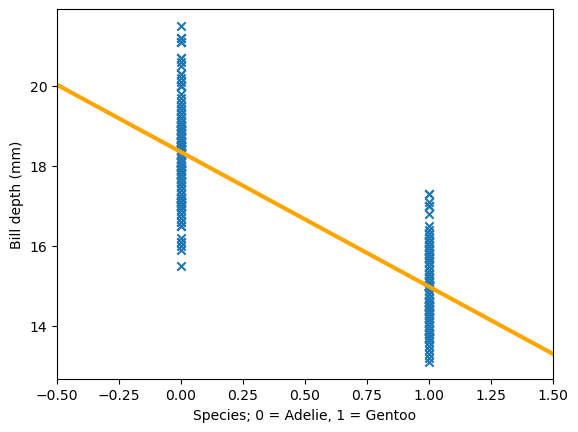

In [118]:
model = sklearn.linear_model.LinearRegression()
model.fit(species[:, np.newaxis], bill_depth)

model_x = np.linspace(-0.5, 1.5, 2)
model_y = model.predict(model_x[:, np.newaxis])

fig, ax = plt.subplots()

ax.scatter(species, bill_depth, marker="x")
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.set_xlabel("Species; 0 = Adelie, 1 = Gentoo")
ax.set_ylabel("Bill depth (mm)")
ax.set_xlim(-0.5, 1.5)

None

The fit value at 0 is the average Adelie bill depth and the fit value at 1 is the average Gentoo bill depth.

But if the model is supposed to _predict_ the categorical data, as an output of the model, then a linear fit is not meaningful:

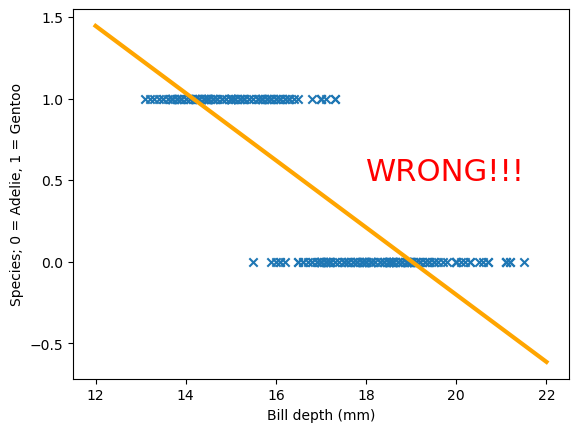

In [272]:
model = sklearn.linear_model.LinearRegression()
model.fit(bill_depth[:, np.newaxis], species)

model_x = np.linspace(12, 22, 2)
model_y = model.predict(model_x[:, np.newaxis])

fig, ax = plt.subplots()

ax.scatter(bill_depth, species, marker="x")
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.set_xlabel("Bill depth (mm)")
ax.set_ylabel("Species; 0 = Adelie, 1 = Gentoo")

ax.text(18, 0.5, "WRONG!!!", color="red", size=22)

None

Whether the model is predicting an allowed species value of 0 or 1, an intermediate value like 0.5, or an out-of-bounds value like 1.5, it's not expressing anything that means anything to us.

Since a linear fit or neural network has to predict continuous numerical values, we can make them useful and interpret them as probabilities. In the training dataset, "0 = Adelie, 1 = Gentoo" can be interpreted as the probability of Gentoo.

The sigmoid function from the previous lecture,

$$ p(x) = \frac{1}{1 + \exp(x)} $$

clamps the output value of the model between 0 and 1, and a loss function of

<!--
$$ \mathcal{L}_k(x_i) = \left\{\begin{array}{l l}
-\log (p_k(x_i)) & \mbox{if species of } x_i \mbox{ is } k \\
-\log (1 - p_k(x_i)) & \mbox{if species of } x_i \mbox{ is not } k \\
\end{array}\right. $$
-->

$$ \mbox{loss}(x_i, y_i) = -(y_i) \log \big[ p(x_i) \big] - (1 - y_i) \log \big[ 1 - p(x_i) \big] $$

optimizes a linear model to predict probabilities $p(x_i)$ that match the given probabilities $y_i$.

In Scikit-Learn, this is

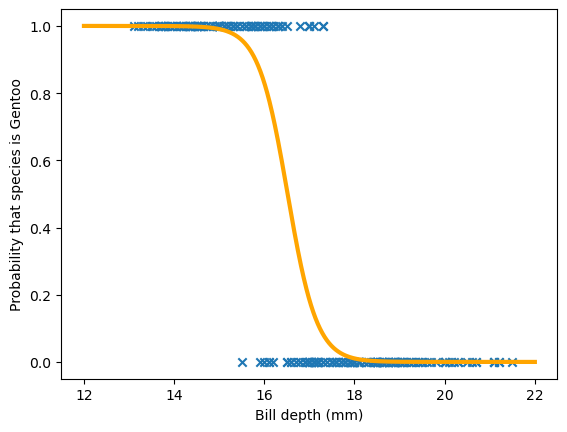

In [134]:
model = sklearn.linear_model.LogisticRegression(penalty=None)
model.fit(bill_depth[:, np.newaxis], species)

model_x = np.linspace(12, 22, 1000)
model_y = model.predict_proba(model_x[:, np.newaxis])[:, 1]

fig, ax = plt.subplots()

ax.scatter(bill_depth, species, marker="x")
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.set_xlabel("Bill depth (mm)")
ax.set_ylabel("Probability that species is Gentoo")

None

<br><br><br><br><br>

2 lines of code in Scikit-Learn becomes a class definition, 8 lines of initialization, and an explicit 5-line loop over training steps in PyTorch.

In [374]:
# this user-defined model step centers and scales the input
# without this, the optimizer would require many more steps to find the minimum
class NormalizeInput(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor([mean], dtype=torch.float32))
        self.register_buffer("std", torch.tensor([std], dtype=torch.float32))
    def forward(self, x):
        return (x - self.mean) / self.std

normalize_input = NormalizeInput(bill_depth.mean(), bill_depth.std())

model = nn.Sequential(      # define a 3-step model
    normalize_input,        # step 1: center/scale the input
    nn.Linear(1, 1),        # step 2: linear transformation (1D → 1D)
    nn.Sigmoid(),           # step 3: pass output through a sigmoid
)

# convert the data into PyTorch Tensors, which are differentiable and can live on a GPU
features = torch.tensor(bill_depth[:, np.newaxis], dtype=torch.float32)
targets = torch.tensor(species[:, np.newaxis], dtype=torch.float32)

# use Binary Cross Entropy as a loss function
loss_function = nn.BCELoss()

# use Adam as an optimizer with a (high) learning rate of 0.03
optimizer = optim.Adam(model.parameters(), lr=0.03)

# iterate over the same data 1000 times (epochs)
for epoch in range(1000):
    # tell the optimizer to begin an optimization step
    optimizer.zero_grad()

    # give the model the input features and ask it to compute its predictions
    predictions = model(features)

    # compute the loss between these predictions and the intended targets
    loss = loss_function(predictions, targets)

    # tell the loss function and optimizer to end an optimization step
    loss.backward()
    optimizer.step()

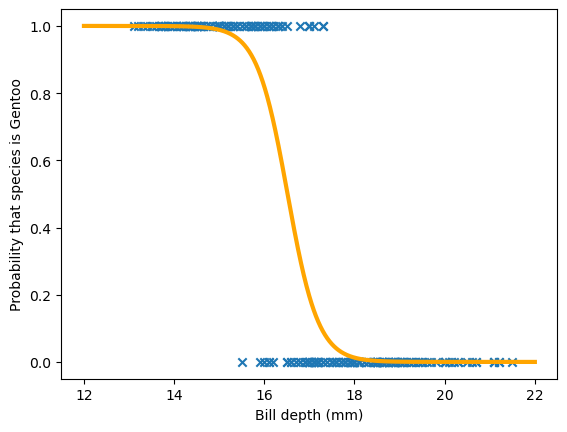

In [375]:
model_x = np.linspace(12, 22, 1000)
model_y = model(torch.tensor(model_x[:, np.newaxis], dtype=torch.float32)).detach().numpy()

fig, ax = plt.subplots()

ax.scatter(bill_depth, species, marker="x")
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.set_xlabel("Bill depth (mm)")
ax.set_ylabel("Probability that species is Gentoo")

None

<br><br><br><br><br>

PyTorch makes all of the steps explicit, and that's (eventually) a good thing because we can change any step of the process.

The steps that distinguish regression from classification are

* including [nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) as the last step of the `model`
* using [nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) instead of [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) as the loss function.

The `NormalizeInput` class is an example of a user-defined model step to center and scale the input. Without it, the fit would be much slower. If I pre-processed the data manually, I'd have to remember to apply the same pre-processing on the training and prediction data.

<br><br><br><br><br>

In [276]:
loss_function = nn.MSELoss()

In [277]:
loss_function(torch.tensor([1.0]), torch.tensor([1.0]))

tensor(0.)

In [278]:
loss_function(torch.tensor([2.0]), torch.tensor([1.0]))

tensor(1.)

In [279]:
loss_function(torch.tensor([3.0]), torch.tensor([1.0]))

tensor(4.)

In [280]:
loss_function(torch.tensor([4.0]), torch.tensor([1.0]))

tensor(9.)

<br><br><br><br><br>

In [304]:
loss_function = nn.BCELoss()

In [305]:
loss_function(torch.tensor([0.0001]), torch.tensor([1.0]))

tensor(9.2103)

In [313]:
-np.log(0.0001)

9.210340371976182

In [307]:
loss_function(torch.tensor([0.001]), torch.tensor([1.0]))

tensor(6.9078)

In [308]:
loss_function(torch.tensor([0.01]), torch.tensor([1.0]))

tensor(4.6052)

In [309]:
loss_function(torch.tensor([0.1]), torch.tensor([1.0]))

tensor(2.3026)

In [310]:
loss_function(torch.tensor([0.5]), torch.tensor([1.0]))

tensor(0.6931)

In [311]:
loss_function(torch.tensor([1.0]), torch.tensor([1.0]))

tensor(0.)

<br><br><br><br><br>

Now suppose that we have more than two classes:

In [316]:
adelie_df = penguins_df[penguins_df["species"] == "Adelie"][["bill_length_mm", "bill_depth_mm"]].dropna()
gentoo_df = penguins_df[penguins_df["species"] == "Gentoo"][["bill_length_mm", "bill_depth_mm"]].dropna()
chinstrap_df = penguins_df[penguins_df["species"] == "Chinstrap"][["bill_length_mm", "bill_depth_mm"]].dropna()

Can we define a species variable that takes values 0, 1, and 2?

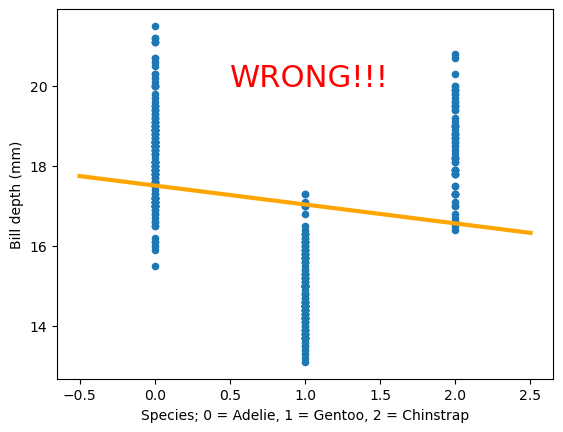

In [329]:
adelie_df["species"] = 0
gentoo_df["species"] = 1
chinstrap_df["species"] = 2

ordinal_df = pd.concat([adelie_df, gentoo_df, chinstrap_df])

model = sklearn.linear_model.LinearRegression()
model.fit(ordinal_df["species"].values[:, np.newaxis], ordinal_df["bill_depth_mm"].values)

model_x = np.linspace(-0.5, 2.5, 2)
model_y = model.predict(model_x[:, np.newaxis])

fig, ax = plt.subplots()

ordinal_df.plot.scatter("species", "bill_depth_mm", ax=ax)
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.set_xlabel("Species; 0 = Adelie, 1 = Gentoo, 2 = Chinstrap")
ax.set_ylabel("Bill depth (mm)")

ax.text(0.5, 20, "WRONG!!!", color="red", size=22)

None

Unlike the case with only 2 values for species, the fit is now finding the _order_ and the _distances_ between the values 0, 1, and 2 to be meaningful: it's interpreting species as interval numbers, rather than nominal categories.

(With more parameters in the fit, we can wash away that interpretation: for instance, fitting the three categories with a parabola that goes through the mean of each. Neural networks with enough parameters can lose knowledge of the order and distances between integer encodings, so it can be okay in those contexts.)

<br><br><br><br><br>

Instead, expand a categorical variable with $n$ categories into $n$ variables whose values are 0 and 1:

In [330]:
adelie_df["is_adelie"] = 1
gentoo_df["is_gentoo"] = 1
chinstrap_df["is_chinstrap"] = 1

onehot_df = pd.concat([adelie_df, gentoo_df, chinstrap_df]).fillna(0)
onehot_df

,bill_length_mm,bill_depth_mm,species,is_adelie,is_gentoo,is_chinstrap
0,39.1,18.7,0,1.0,0.0,0.0
1,39.5,17.4,0,1.0,0.0,0.0
2,40.3,18.0,0,1.0,0.0,0.0
4,36.7,19.3,0,1.0,0.0,0.0
5,39.3,20.6,0,1.0,0.0,0.0
...,...,...,...,...,...,...
339,55.8,19.8,2,0.0,0.0,1.0
340,43.5,18.1,2,0.0,0.0,1.0
341,49.6,18.2,2,0.0,0.0,1.0
342,50.8,19.0,2,0.0,0.0,1.0


For historical reasons, this is called a [one-hot encoding](https://en.wikipedia.org/wiki/One-hot).

The three new features, `is_adelie`, `is_gentoo`, and `is_chinstrap`, can be interpreted as given probabilities, and therefore either 0 and 1. They're constrained to have `is_adelie + is_gentoo + is_chinstrap = 1`. In principle, we only need $n - 1$ variables, since one is determined by the others.

<br><br><br><br><br>

Here's a logistic regression in Scikit-Learn, using bill length and bill depth as 2 input features to predict 3 probabilities `is_adelie`, `is_gentoo`, `is_chinstrap`:

In [403]:
features_np = onehot_df[["bill_length_mm", "bill_depth_mm"]].values
targets_np = onehot_df[["is_adelie", "is_gentoo", "is_chinstrap"]].values

In [404]:
model = sklearn.linear_model.LogisticRegression(penalty=None)

# Scikit-Learn wants the target index, rather than the target values themselves, so np.argmax
model.fit(features_np, np.argmax(targets_np, axis=1))

None

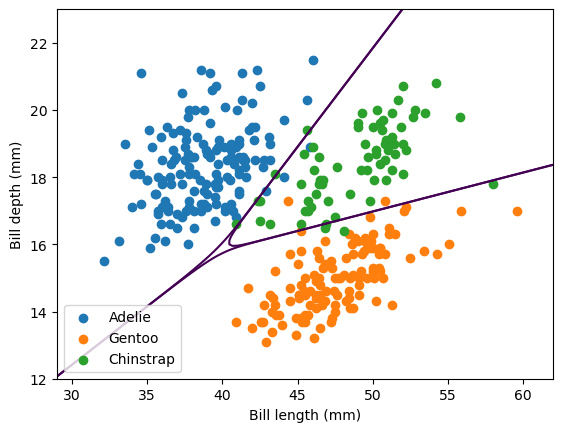

In [405]:
fig, ax = plt.subplots()

# draw three scatter plots, each a different color
ax.scatter(features_np[targets_np[:, 0] == 1, 0], features_np[targets_np[:, 0] == 1, 1])
ax.scatter(features_np[targets_np[:, 1] == 1, 0], features_np[targets_np[:, 1] == 1, 1])
ax.scatter(features_np[targets_np[:, 2] == 1, 0], features_np[targets_np[:, 2] == 1, 1])

# compute the three probabilities for every 2D point in the background
background_x, background_y = np.meshgrid(np.linspace(29, 62, 100), np.linspace(12, 23, 100))
background_2d = np.column_stack([background_x.ravel(), background_y.ravel()])
probabilities = model.predict_proba(background_2d)

# draw contour lines where the probabilities cross the 50% threshold
ax.contour(background_x, background_y, probabilities[:, 0].reshape(background_x.shape), [0.5])
ax.contour(background_x, background_y, probabilities[:, 1].reshape(background_x.shape), [0.5])
ax.contour(background_x, background_y, probabilities[:, 2].reshape(background_x.shape), [0.5])

ax.set_xlabel("Bill length (mm)")
ax.set_ylabel("Bill depth (mm)")
ax.axis([29, 62, 12, 23])

ax.legend(["Adelie", "Gentoo", "Chinstrap"])

None

<br><br><br><br><br>

### Small exercise: do the same fit in PyTorch

In [438]:
features = torch.tensor(features_np, dtype=torch.float32)
targets = torch.tensor(np.argmax(targets_np, axis=1))

In [439]:
# features

In [441]:
# targets

In [449]:
class NormalizeInput(nn.Module):
    def __init__(self, mean1, std1, mean2, std2):
        super().__init__()
        self.register_buffer("mean", torch.tensor([mean1, mean2], dtype=torch.float32))
        self.register_buffer("std", torch.tensor([std1, std2], dtype=torch.float32))
    def forward(self, x):
        return (x - self.mean) / self.std

normalize_input = NormalizeInput(
    features_np[:, 0].mean(), features_np[:, 0].std(),
    features_np[:, 1].mean(), features_np[:, 1].std(),
)
# normalize_input.forward(features)

In [450]:
model = nn.Sequential(
    normalize_input,
    nn.Linear(2, 3),
    nn.LogSoftmax(dim=1),
)
# model

In [451]:
# model(features)

In [452]:
loss_function = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr=0.03)

for epoch in range(1000):
    optimizer.zero_grad()

    predictions = model(features)

    loss = loss_function(predictions, targets)

    loss.backward()
    optimizer.step()

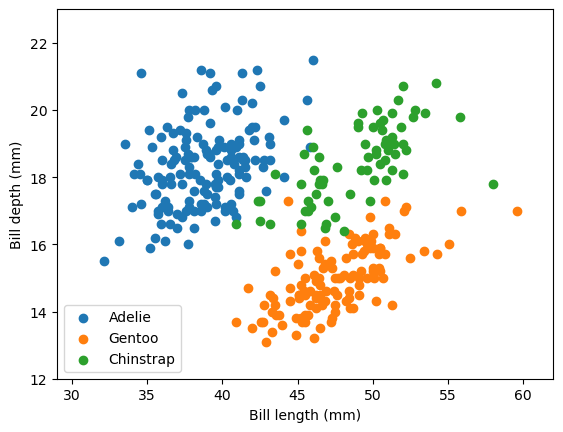

In [448]:
fig, ax = plt.subplots()

# draw three scatter plots, each a different color
ax.scatter(features_np[targets_np[:, 0] == 1, 0], features_np[targets_np[:, 0] == 1, 1])
ax.scatter(features_np[targets_np[:, 1] == 1, 0], features_np[targets_np[:, 1] == 1, 1])
ax.scatter(features_np[targets_np[:, 2] == 1, 0], features_np[targets_np[:, 2] == 1, 1])

# compute the three probabilities for every 2D point in the background
background_x, background_y = np.meshgrid(np.linspace(29, 62, 100), np.linspace(12, 23, 100))
background_2d = np.column_stack([background_x.ravel(), background_y.ravel()])
probabilities = model(torch.tensor(background_2d, dtype=torch.float32)).detach().numpy()

# draw contour lines where the probabilities cross the 50% threshold
ax.contour(background_x, background_y, probabilities[:, 0].reshape(background_x.shape), [0.5])
ax.contour(background_x, background_y, probabilities[:, 1].reshape(background_x.shape), [0.5])
ax.contour(background_x, background_y, probabilities[:, 2].reshape(background_x.shape), [0.5])

ax.set_xlabel("Bill length (mm)")
ax.set_ylabel("Bill depth (mm)")
ax.axis([29, 62, 12, 23])

ax.legend(["Adelie", "Gentoo", "Chinstrap"])

None

<br><br><br><br><br>

## Optimizers: learning rate, batches, and epochs

<br><br><br><br><br>

## Feature selection and the "kernel trick"

<br><br><br><br><br>

## Under & overfitting

<br><br><br><br><br>

## Parameters versus hyperparameters

<br><br><br><br><br>

## Partitioning data into train-test-validate

<br><br><br><br><br>

## Goodness of fit metrics

<br><br><br><br><br>

## Regularization: L1, L2, dropout

<br><br><br><br><br>